In [1]:
import torch
import torchvision

# datasets
from datasets.esri_datascience_challenge_2019 import ESRI_challenge_2019
from datasets.dota_loader import DOTA
from datasets import dota_loader
from datasets import esri_datascience_challenge_2019

# models
from models.fastrcnn import FastRCNN
from models.retinanet import RetinaNet

# vizualization
from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib as mpl
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Define either of the two datasets:

### ESRI challenge

In [4]:
dataset = ESRI_challenge_2019 (root = "E:\\AiTLAS\\aitlas\\ESRI-challenge\\data\\ESRI",
                               subset = "train", 
                               subsample_percentage = 1, 
                               batch_size = 4, 
                               shuffle = True, 
                               num_workers = 0)

dataset_test = ESRI_challenge_2019 (root = "E:\\AiTLAS\\aitlas\\ESRI-challenge\\data\\ESRI",
                               subset = "test", 
                               subsample_percentage = 1, 
                               batch_size = 4, 
                               shuffle = True, 
                               num_workers = 0) 

The original number of images was: 3228
The subsampled number of images is: 3228
The original number of images was: 520
The subsampled number of images is: 520


### DOTA

In [3]:
dataset = DOTA (root = "E:\\AiTLAS\\aitlas\\ESRI-challenge\\data\\DOTA",
                subset = "train_split", 
                subsample_percentage = 0.1, 
                batch_size = 2, 
                shuffle = True, 
                num_workers = 0, 
                filter_null = True)

dataset_test = DOTA (root = "E:\\AiTLAS\\aitlas\\ESRI-challenge\\data\\DOTA",
                     subset = "validation_split", 
                     subsample_percentage = 0.01, 
                     batch_size = 2, 
                     shuffle = True, 
                     num_workers = 0,
                     filter_null = True)

The original number of images is: 177228
After filtering the number of images is: 46117
The subsampled number of images is: 4611
The original number of images is: 234316
After filtering the number of images is: 61939
The subsampled number of images is: 619


## Plot examples of dataset annotations

In [11]:
num_examples = 40
# choose between 'esri' & 'dota'
dataset_name = 'dota'
num_images = dataset.__len__()

example_ind = np.random.randint(0, num_images, size = num_examples)

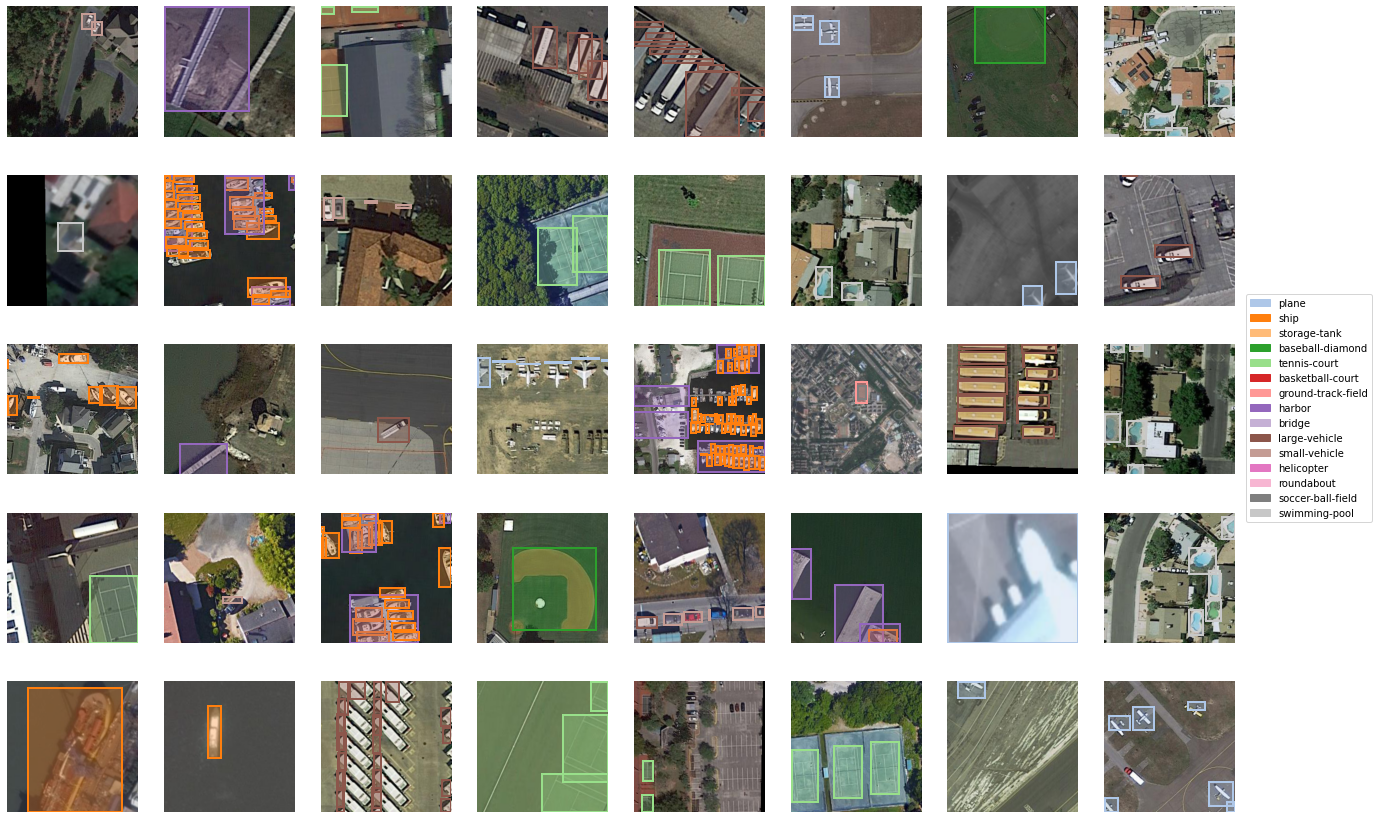

In [12]:
fig, axes = plt.subplots(nrows = 5, ncols = 8, figsize = (22, 15))

for (example_idx, ax) in zip(example_ind, axes.flatten()):
    image, labels = dataset.__getitem__(example_idx)
    img = image.cpu().numpy().copy()
    img = np.rollaxis(img, 0, 3)
    img = (img*255).astype(np.uint16)

    ax.imshow(img)

    for (box, label) in zip(labels['boxes'].cpu().numpy().astype(np.int32), labels['labels'].cpu().numpy()):        
        tab20 = mpl.cm.get_cmap('tab20', 20)
        ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor=tab20(label), linewidth = 2, facecolor='none'))
        ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor=tab20(label), facecolor=tab20(label), alpha=0.3))
        ax.axis('off')

    
    tab20 = mpl.cm.get_cmap('tab20', 20)
    legend_items = []
    if dataset_name == 'dota':
        for cat, value in dota_loader.category_mapping.items():
            legend_items.append(patches.Patch(color=tab20(value), label=cat))
    else:
        for cat, value in esri_datascience_challenge_2019.category_mapping.items():
            legend_items.append(patches.Patch(color=tab20(value), label=cat))
    plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 4.), handles = legend_items)
        
plt.show()

## Model getter functions

In [4]:
def get_fastrcnn(num_classes = 3):
    model_cfg = {"num_classes": num_classes, "learning_rate": 0.001, "pretrained": True}

    # load a model pre-trained on COCO
    model = FastRCNN(model_cfg)

    model.prepare()

    return model

def get_retinanet(num_classes = 3):
    model_cfg = {"num_classes": num_classes, "learning_rate": 0.001, "pretrained": True}
    
    model = RetinaNet(model_cfg)

    model.prepare()
    
    return model

## Test the performance of FastRCNN

In [5]:
# get the model using our helper function
model = get_fastrcnn(num_classes = 3)

model.train_and_evaluate_model(
    train_dataset=dataset,
    val_dataset=dataset_test,
    epochs=3,
    model_directory = "./experiment/",
    run_id = "esri-fastrcnn",
    iterations_log = 40
)

2021-09-15 07:51:58,533 INFO Starting training.
training:   4%|▎         | 30/807 [00:20<08:20,  1.55it/s]

KeyboardInterrupt: 

## Test the performance of RetinaNet

In [5]:
# get the model using our helper function
model = get_retinanet(num_classes = 3)

model.train_and_evaluate_model(
    train_dataset=dataset,
    val_dataset=dataset_test,
    epochs=20,
    model_directory = "./experiment/",
    run_id = "esri-retinanet",
    iterations_log = 40
)

2021-09-14 22:14:17,935 INFO Starting training.
training: 100%|██████████| 507/507 [04:42<00:00,  1.79it/s]
2021-09-14 22:19:01,020 INFO epoch: 1, time: 283, loss:  0.97976
testing on train set: 100%|██████████| 507/507 [02:19<00:00,  3.63it/s]
2021-09-14 22:27:21,687 INFO Mean Average Precision:0.7647022
testing on validation set: 100%|██████████| 83/83 [00:25<00:00,  3.27it/s]
2021-09-14 22:28:59,975 INFO Mean Average Precision:0.5804063
training: 100%|██████████| 507/507 [04:38<00:00,  1.82it/s]
2021-09-14 22:33:38,880 INFO epoch: 2, time: 279, loss:  0.75101
testing on train set: 100%|██████████| 507/507 [02:16<00:00,  3.72it/s]
2021-09-14 22:40:28,890 INFO Mean Average Precision:0.6830958
testing on validation set: 100%|██████████| 83/83 [00:21<00:00,  3.84it/s]
2021-09-14 22:41:57,729 INFO Mean Average Precision:0.60181963
training: 100%|██████████| 507/507 [04:38<00:00,  1.82it/s]
2021-09-14 22:46:36,655 INFO epoch: 3, time: 279, loss:  0.44775
testing on train set: 100%|███████